In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
%matplotlib inline

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
from lib import NERCOME, shrinkage

In [47]:
# Parameters
p = 30
n = 1000
mean = 0
sigmaA = 1
sigmaB = np.sqrt(5)

# Target matrix
T = 3*np.identity(p)

# Build true covariance matrix
C_true_A = np.full(p//2, sigmaA**2)
C_true_B = np.full(p-p//2, sigmaB**2)
C_true = np.diag(np.concatenate((C_true_A, C_true_B)))

MSE_sample_all = []
MSE_shrinkage_all = []
MSE_nercome_all = []

evals_MC_sum = np.zeros(p)
evals_MCS_sum = np.zeros(p)
evals_NERCOME_sum = np.zeros(p)

lmbda_est_all = []
s_min_all = []

# Number of simulations
m = 100
for _ in range(m):
    # Build random matrix
    A = np.random.normal(mean, sigmaA, size=(p//2, n))
    B = np.random.normal(mean, sigmaB, size=(p-p//2, n))
    X = np.vstack((A, B))
    
    # Perform imported algorithms
    C_shrinkage, S1, lmbda_est = shrinkage.shrinkage_cov_matrix(X, T)
    C_nercome, S2, s_min = NERCOME.NERCOME(X)
    
    # We require the empirically estimated covariance matrices to be (almost) identical
    assert np.allclose(S1, S2, 0, 1e-10)
    
    MSE_sample = np.trace((S1-C_true)@(S1-C_true).T)
    MSE_shrinkage = np.trace((C_shrinkage-C_true)@(C_shrinkage-C_true).T)
    MSE_nercome = np.trace((C_nercome-C_true)@(C_nercome-C_true).T)
    
    MSE_sample_all.append(MSE_sample)
    MSE_shrinkage_all.append(MSE_shrinkage)
    MSE_nercome_all.append(MSE_nercome)
    
    evals_MC = np.linalg.eigvalsh(S1)
    evals_MCS = np.linalg.eigvalsh(C_shrinkage)
    evals_NERCOME = np.linalg.eigvalsh(C_nercome)
    
    evals_MC_sum += evals_MC
    evals_MCS_sum += evals_MCS
    evals_NERCOME_sum += evals_NERCOME
    lmbda_est_all.append(lmbda_est)
    s_min_all.append(s_min)

MSE_sample = np.average(MSE_sample_all)
MSE_shrinkage = np.average(MSE_shrinkage_all)
MSE_nercome = np.average(MSE_nercome_all)

MSE_sample_se = np.std(MSE_sample_all) / np.sqrt(m)
MSE_shrinkage_se = np.std(MSE_shrinkage_all) / np.sqrt(m)
MSE_nercome_se = np.std(MSE_nercome_all) / np.sqrt(m)    

evals_MC = evals_MC_sum / m
evals_MCS = evals_MCS_sum / m
evals_NERCOME_sum = evals_NERCOME / m

lmbda_est = np.average(lmbda_est_all)
lmbda_est_se = np.std(lmbda_est_all) / np.sqrt(m)

s_min = np.average(s_min_all)
s_min_se = np.std(s_min_all) / np.sqrt(m)

print(f"Lambda: {lmbda_est} ± {lmbda_est_se}")
print(f"s which minimizes Q: {s_min} ± {s_min_se}")

print(f"MSE Sample: {MSE_sample} ± {MSE_sample_se}")
print(f"MSE Shrinkage: {MSE_shrinkage} ± {MSE_shrinkage_se}")
print(f"MSE NERCOME: {MSE_nercome} ± {MSE_nercome_se}")

Lambda: 0.06608418424041254 ± 9.702473911601226e-05
s which minimizes Q: 572.5 ± 17.865819320702872
MSE Sample: 8.540571763570785 ± 0.07858235050834003
MSE Shrinkage: 7.987172647979091 ± 0.06465269558706578
MSE NERCOME: 2.6131916623360123 ± 0.03218449787211043


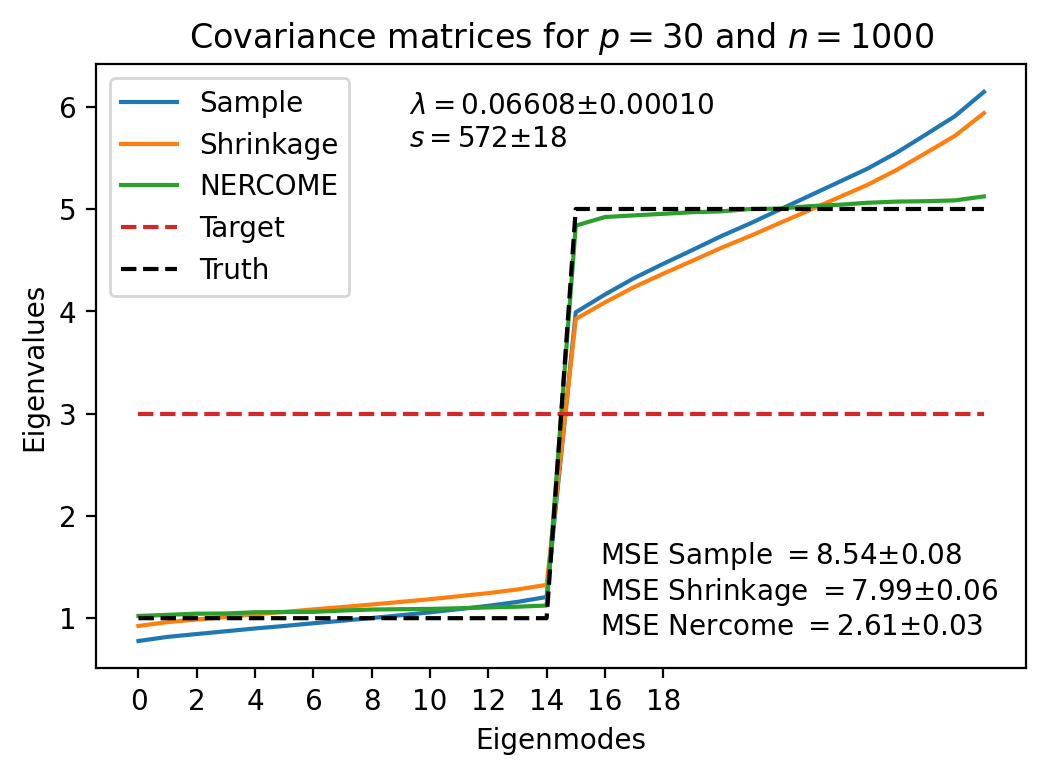

In [53]:
evals_T = np.linalg.eigvalsh(T)
evals_true = np.linalg.eigvalsh(C_true)

plt.figure(dpi=200)
plt.plot(evals_MC, label="Sample")
plt.plot(evals_MCS, label="Shrinkage")
plt.plot(evals_NERCOME, label="NERCOME")
plt.plot(evals_T, "--", label="Target")
plt.plot(evals_true, "k--", label="Truth")
plt.legend()
plt.title(fr"Covariance matrices for $p={p}$ and $n={n}$")
plt.xlabel("Eigenmodes")
plt.xticks(np.arange(0, 19, 2))
plt.ylabel("Eigenvalues")

estimator_parameters = AnchoredText(
    fr"$\lambda = {np.round(lmbda_est, 5)} ± {np.round(lmbda_est_se, 5)}$"
    "\n"
    fr"$s = {int(np.round(s_min, 0))} ± {int(np.round(s_min_se, 0))}$",
    frameon=False, loc="upper center", pad=0.5
)
plt.setp(estimator_parameters.patch, facecolor='white', alpha=0.5)
plt.gca().add_artist(estimator_parameters)

error_parameters = AnchoredText(
    fr"MSE Sample $= {float(np.round(MSE_sample, 2))} ± {float(np.round(MSE_sample_se, 2))}$"
    "\n"
    fr"MSE Shrinkage $= {np.round(MSE_shrinkage, 2)} ± {np.round(MSE_shrinkage_se, 2)}$"
    "\n"
    fr"MSE Nercome $= {np.round(MSE_nercome, 2)} ± {np.round(MSE_nercome_se, 2)}$",
    frameon=False, loc="lower right", pad=0.5
)
plt.setp(error_parameters.patch, facecolor='white', alpha=0.5)
plt.gca().add_artist(error_parameters)